In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import chardet as chardet
import dask as dask
import dask.dataframe as dd

import sys
import subprocess
from pathlib import Path

# Import Dependencies
import psycopg2
from pymongo import MongoClient
from pprint import pprint
from utils import createCSV, createCSVUsingDask

In [2]:
def createUSAccidentData(base_path):
    createCSV(f"{base_path}/2022/accident.csv","Resources/accident_labels.csv","us_accident","w")
    createCSV(f"{base_path}/2021/accident.csv","Resources/accident_labels.csv","us_accident","a")
    createCSV(f"{base_path}/2020/accident.csv","Resources/accident_labels.csv","us_accident","a")
    createCSV(f"{base_path}/2019/accident.csv","Resources/accident_labels.csv","us_accident","a")

In [3]:
import import_ipynb as ipynb
def loadUSAccidentDataToMongoDB():
    object_names = ['us_accident']
    # Pass the collection names
    from mongodb_load_databases import createMongoDB, validateMongoDB
    db_name = 'us_accidents_db'
    createMongoDB(db_name, object_names)
    validateMongoDB(db_name)

In [4]:
import import_ipynb as ipynb
def loadUSAccidentDataToMongoDBCluster():
    object_names = ['us_accident']
    # Pass the collection names
    from mongodb_load_databases import createMongoDBCluster, validateMongoDBCluster
    db_name = 'us_accidents_db'
    createMongoDBCluster(db_name, object_names)
    validateMongoDBCluster(db_name)

In [5]:
base_path = Path("Resources/accident_data")
createUSAccidentData(base_path)
loadUSAccidentDataToMongoDB()

Starting to read the File
################Labels to Save###################### Index(['STATE', 'STATENAME', 'ST_CASE', 'VE_TOTAL', 'PVH_INVL', 'PEDS',
       'PERSONS', 'PERMVIT', 'PERNOTMVIT', 'COUNTYNAME', 'CITYNAME', 'DAY',
       'MONTH', 'MONTHNAME', 'YEAR', 'DAY_WEEK', 'DAY_WEEKNAME', 'HOUR',
       'HOURNAME', 'MINUTE', 'NHSNAME', 'ROUTENAME', 'TWAY_ID', 'RUR_URBNAME',
       'FUNC_SYSNAME', 'RD_OWNERNAME', 'WEATHERNAME', 'LATITUDE', 'LONGITUD',
       'SP_JURNAME', 'HARM_EVNAME', 'RELJCT1NAME', 'WRK_ZONENAME',
       'REL_ROADNAME', 'LGT_CONDNAME', 'FATALS'],
      dtype='object')
################Updated CSV File#################        STATE STATENAME  ST_CASE  PEDS  PERNOTMVIT  VE_TOTAL  PVH_INVL  \
0          1   Alabama    10001     0           0         2         0   
1          1   Alabama    10002     0           0         2         0   
2          1   Alabama    10003     0           0         1         0   
3          1   Alabama    10004     0           0         1   

In [6]:
# Import dependencies
from pymongo import MongoClient
from pprint import pprint

# Create an instance of MongoClient
mongo = MongoClient(port=27017)

# confirm that the "autosaurus" database is in MongoDB
print(mongo.list_database_names())

['admin', 'config', 'local', 'us_accidents_db']


In [7]:
# assign the database to a variable name
db = mongo['us_accidents_db']
# review the collections in our new database
print(db.list_collection_names())

['us_accident']


In [8]:
# assign each collection to a variable
accident = db['us_accident']

In [9]:
#Calculate total fatalities over all years
total_fatalities = accident.count_documents({})
#Display the data
print("Total Fatalities: ", total_fatalities)

Total Fatalities:  148428


In [10]:
#Calculate fatalities by year
pipeline_year = [
    {"$group": {"_id": "$YEAR", "FATALS": {"$sum": 1}}},
    {"$sort": {"_id": -1}}  # Sort by year descending
]
fatalities_by_year = list(accident.aggregate(pipeline_year))
df_year = pd.DataFrame(fatalities_by_year).rename(columns={'_id': 'Year'})

print("\nFatalities by Year:")
print(df_year)


Fatalities by Year:
   Year  FATALS
0  2022   39221
1  2021   39785
2  2020   35935
3  2019   33487


In [11]:
pipeline_state = [
    {"$group":{"_id": "$STATENAME", "FATALS": {"$sum": 1}}},
    {"$sort": {"FATALS": -1}}  # Sort by fatalities descending
]
fatalities_by_state = list(accident.aggregate(pipeline_state))
df_state = pd.DataFrame(fatalities_by_state).rename(columns={'_id': 'State'})
print("\nFatalities by State:")
print(df_state)



Fatalities by State:
                   State  FATALS
0             California   15405
1                  Texas   14854
2                Florida   12800
3                Georgia    6254
4         North Carolina    5836
5                   Ohio    4615
6              Tennessee    4604
7               Illinois    4381
8           Pennsylvania    4295
9                Arizona    4133
10              Michigan    4043
11              New York    4040
12        South Carolina    4022
13              Missouri    3626
14               Alabama    3506
15              Virginia    3422
16               Indiana    3314
17             Louisiana    3181
18              Kentucky    2803
19           Mississippi    2606
20              Oklahoma    2508
21              Colorado    2456
22            New Jersey    2377
23            Washington    2350
24              Arkansas    2284
25             Wisconsin    2206
26              Maryland    2098
27                Oregon    2020
28            New Mex

In [12]:
#Calculate fatalities by state
def groupByStateAndYear(collection_obj):
    pipeline_state = [
        {"$group": {"_id": {"Year":"$YEAR","StateID":"$STATE","State":"$STATENAME"}, "Fatal Crashes": {"$sum": 1}}},
        {"$sort": {"_id.Year":-1 ,"_id.State": 1}}  # Sort by fatalities descending
    ]
    result = list(collection_obj.aggregate(pipeline_state))
    
    # Convert to DataFrame
    df_state = pd.DataFrame(result)
    
    # Flatten the DataFrame
    df_state = pd.concat([df_state.drop(['_id'], axis=1), df_state['_id'].apply(pd.Series)], axis=1)
    df_state = df_state.reindex(columns=['StateID','Year','State','Fatal Crashes'])
    print("\nFatalities by State:")
    print(df_state)


In [13]:
groupByStateAndYear(accident)


Fatalities by State:
     StateID  Year          State  Fatal Crashes
0          1  2022        Alabama            913
1          2  2022         Alaska             75
2          4  2022        Arizona           1183
3          5  2022       Arkansas            583
4          6  2022     California           4109
..       ...   ...            ...            ...
199       51  2019       Virginia            774
200       53  2019     Washington            513
201       54  2019  West Virginia            247
202       55  2019      Wisconsin            527
203       56  2019        Wyoming            120

[204 rows x 4 columns]


In [14]:
#Calculate fatalities by "Monthwise only"
pipeline_month = [
    {"$group": {"_id": {"Year":"$YEAR","MonthID":"$MONTH", "Month":"$MONTHNAME"}, "Fatal Crashes": {"$sum": 1}}},
    {"$sort": {"_id.MonthID":1,"_id.Year":-1}}  # Sort by month name alphabetically
]
result = list(accident.aggregate(pipeline_month))
# Convert to DataFrame
df_month = pd.DataFrame(result)

# Flatten the DataFrame
df_month = pd.concat([df_month.drop(['_id'], axis=1), df_month['_id'].apply(pd.Series)], axis=1)
df_month = df_month.reindex(columns=['MonthID','Month','Year','Fatal Crashes'])
print("\nFatalities by Month:")
print(df_month)



Fatalities by Month:
    MonthID      Month  Year  Fatal Crashes
0         1    January  2022           2946
1         1    January  2021           2837
2         1    January  2020           2486
3         1    January  2019           2476
4         2   February  2022           2748
5         2   February  2021           2351
6         2   February  2020           2453
7         2   February  2019           2205
8         3      March  2022           3050
9         3      March  2021           2916
10        3      March  2020           2375
11        3      March  2019           2544
12        4      April  2022           2951
13        4      April  2021           3285
14        4      April  2020           2130
15        4      April  2019           2611
16        5        May  2022           3376
17        5        May  2021           3440
18        5        May  2020           2876
19        5        May  2019           2917
20        6       June  2022           3359
21        

In [22]:
#Calculate fatalities by Hour & Week
pipeline_hour = [
{"$match": {"HOUR": {"$lte": 23}}},
{"$group": {"_id": {"Year":"$YEAR","WeekID":"$DAY_WEEK","Week Name":"$DAY_WEEKNAME","HourID":"$HOUR","Hour":"$HOURNAME"}, "Fatal Crashes": {"$sum": 1}}},
{"$sort": {"_id.Year":-1,"_id.WeekID":1,'_id.HourID':1}}
]
result = list(accident.aggregate(pipeline_hour))
# Convert to DataFrame
df_hour = pd.DataFrame(result)
    
# Flatten the DataFrame
df_hour = pd.concat([df_hour.drop(['_id'], axis=1), df_hour['_id'].apply(pd.Series)], axis=1)
df_hour = df_hour.reindex(columns=['Year','HourID','Hour','WeekID','Week Name','Fatal Crashes'])
print("\nFatalities by Hour:")
print(df_hour)
    


Fatalities by Hour:
     Year  HourID             Hour  WeekID Week Name  Fatal Crashes
0    2022       0    0:00am-0:59am       1    Sunday            410
1    2022       1    1:00am-1:59am       1    Sunday            397
2    2022       2    2:00am-2:59am       1    Sunday            432
3    2022       3    3:00am-3:59am       1    Sunday            283
4    2022       4    4:00am-4:59am       1    Sunday            219
..    ...     ...              ...     ...       ...            ...
667  2019      19    7:00pm-7:59pm       7  Saturday            331
668  2019      20    8:00pm-8:59pm       7  Saturday            343
669  2019      21    9:00pm-9:59pm       7  Saturday            359
670  2019      22  10:00pm-10:59pm       7  Saturday            330
671  2019      23  11:00pm-11:59pm       7  Saturday            324

[672 rows x 6 columns]


In [16]:
#Calculate fatalities by county
pipeline_county = [
    {"$group": {"_id": {"Year":"$YEAR","StateID":"$STATE","State":"$STATENAME","County": "$COUNTYNAME"}, "Fatal Crashes": {"$sum": 1}}},
    {"$sort": {"_id.State":1,"_id.Year":-1}}  # Sort by county name alphabetically
]
result = list(accident.aggregate(pipeline_county))
# Convert to DataFrame
df_county = pd.DataFrame(result)

# Flatten the DataFrame
df_county = pd.concat([df_county.drop(['_id'], axis=1), df_county['_id'].apply(pd.Series)], axis=1)
df_county  = df_county .reindex(columns=['StateID','State','County','Year','Fatal Crashes'])
print("\nFatalities by County:")
print(df_county)



Fatalities by County:
       StateID    State           County  Year  Fatal Crashes
0            1  Alabama     CULLMAN (43)  2022             27
1            1  Alabama       BLOUNT (9)  2022             12
2            1  Alabama      MOBILE (97)  2022             67
3            1  Alabama     CONECUH (35)  2022              4
4            1  Alabama    CLEBURNE (29)  2022              7
...        ...      ...              ...   ...            ...
11456       56  Wyoming      PLATTE (31)  2019              6
11457       56  Wyoming     NATRONA (25)  2019              7
11458       56  Wyoming     JOHNSON (19)  2019              5
11459       56  Wyoming      GOSHEN (15)  2019              2
11460       56  Wyoming  SWEETWATER (37)  2019             14

[11461 rows x 5 columns]


In [17]:
#Calculate fatalities by city
pipeline_city = [
    {"$group":{"_id":{"Year":"$YEAR","StateID":"$STATE","State":"$STATENAME","City": "$CITYNAME"}, "Fatal Crashes": {"$sum": 1}}},
    {"$sort": {"_id.State": 1,"_id.Year": -1}}  # Sort by city name alphabetically
]
result = list(accident.aggregate(pipeline_city))
# Convert to DataFrame
df_city = pd.DataFrame(result)

# Flatten the DataFrame
df_city = pd.concat([df_city.drop(['_id'], axis=1), df_city['_id'].apply(pd.Series)], axis=1)
df_city  = df_city.reindex(columns=['StateID','State','City','Year','Fatal Crashes'])
print("\nFatalities by City:")
print(df_city)


Fatalities by City:
       StateID    State          City  Year  Fatal Crashes
0            1  Alabama      LEESBURG  2022              2
1            1  Alabama        AUBURN  2022              6
2            1  Alabama   PHENIX CITY  2022              5
3            1  Alabama       LINCOLN  2022              1
4            1  Alabama        TRIANA  2022              1
...        ...      ...           ...   ...            ...
21105       56  Wyoming  ROCK SPRINGS  2019              2
21106       56  Wyoming      CHEYENNE  2019              3
21107       56  Wyoming        LANDER  2019              1
21108       56  Wyoming      GILLETTE  2019              3
21109       56  Wyoming      SHERIDAN  2019              3

[21110 rows x 5 columns]


In [18]:
# #Calculate fatalities by rural vs urban areas
pipeline_rural_urban = [
    # Add a match stage to filter only Rural and Urban entries
    {"$match": {"RUR_URBNAME": {"$in": ["Rural", "Urban"]}}},
    {"$group":{"_id":{"Year":"$YEAR","StateID":"$STATE","State":"$STATENAME","Rural/Urban":"$RUR_URBNAME", "Functional System":"$FUNC_SYSNAME"}, "Fatal Crashes": {"$sum": 1}}},
    {"$sort": {"_id.Year": -1,"_id.StateID":1}}
]
result = list(accident.aggregate(pipeline_rural_urban))
# Convert to DataFrame
df_rural_urban = pd.DataFrame(result)

# Flatten the DataFrame
df_rural_urban = pd.concat([df_rural_urban.drop(['_id'], axis=1), df_rural_urban['_id'].apply(pd.Series)], axis=1)
df_rural_urban  = df_rural_urban.reindex(columns=['StateID','State','Year','Rural/Urban','Functional System','Fatal Crashes'])
print("\nFatalities by Rural/Urban:")
print(df_rural_urban)



Fatalities by Rural/Urban:
      StateID    State  Year Rural/Urban           Functional System  \
0           1  Alabama  2022       Urban                  Interstate   
1           1  Alabama  2022       Rural                  Interstate   
2           1  Alabama  2022       Rural                     Unknown   
3           1  Alabama  2022       Rural              Minor Arterial   
4           1  Alabama  2022       Rural             Minor Collector   
...       ...      ...   ...         ...                         ...   
2661       56  Wyoming  2019       Urban                       Local   
2662       56  Wyoming  2019       Rural                       Local   
2663       56  Wyoming  2019       Urban  Principal Arterial - Other   
2664       56  Wyoming  2019       Rural  Principal Arterial - Other   
2665       56  Wyoming  2019       Rural             Major Collector   

      Fatal Crashes  
0                66  
1                58  
2                 1  
3               106

In [19]:
#Calculate fatalities by Rural/Urban
pipeline_rural_urban = [
    # Add a match stage to filter only Rural and Urban entries
    {"$match": {"RUR_URBNAME": {"$in": ["Rural", "Urban"]}}},
    {"$group":{"_id":{"Year":"$YEAR","Rural/Urban":"$RUR_URBNAME","Functional System":"$FUNC_SYSNAME"}, "Fatal Crashes": {"$sum": 1}}},
    {"$sort": {"_id.Year": -1}}
]
result = list(accident.aggregate(pipeline_rural_urban))
# Convert to DataFrame
df_rural_urban = pd.DataFrame(result)

# Flatten the DataFrame
df_rural_urban = pd.concat([df_rural_urban.drop(['_id'], axis=1), df_rural_urban['_id'].apply(pd.Series)], axis=1)
df_rural_urban  = df_rural_urban.reindex(columns=['Year','Rural/Urban','Functional System','Fatal Crashes'])
print("\nFatalities by Rural/Urban:")
print(df_rural_urban)



Fatalities by Rural/Urban:
    Year Rural/Urban                                  Functional System  \
0   2022       Rural                                    Minor Collector   
1   2022       Rural  Principal Arterial - Other Freeways and Expres...   
2   2022       Urban                                    Major Collector   
3   2022       Urban                                     Minor Arterial   
4   2022       Rural                                            Unknown   
..   ...         ...                                                ...   
65  2019       Urban                                    Major Collector   
66  2019       Urban                                       Not Reported   
67  2019       Urban                                         Interstate   
68  2019       Rural                                    Major Collector   
69  2019       Urban  Principal Arterial - Other Freeways and Expres...   

    Fatal Crashes  
0             937  
1             281  
2          

In [20]:
#Calculate fatalities by Weather
pipeline_weather = [
    {"$group": {"_id":{"Year":"$YEAR","StateID":"$STATE","State":"$STATENAME","Weather":"$WEATHERNAME"}, "Fatal Crashes": {"$sum": 1}}},
    {"$sort": {"_id.State": 1,"_id.Year":-1}}
]
result = list(accident.aggregate(pipeline_weather))
# Convert to DataFrame
df_weather = pd.DataFrame(result)

# Flatten the DataFrame
df_weather = pd.concat([df_weather.drop(['_id'], axis=1), df_weather['_id'].apply(pd.Series)], axis=1)
df_weather  = df_weather.reindex(columns=['StateID','State','Year','Weather','Fatal Crashes'])
print("\nFatalities by Weather:")
print(df_weather)


Fatalities by Weather:
      StateID    State  Year              Weather  Fatal Crashes
0           1  Alabama  2022         Blowing Snow              1
1           1  Alabama  2022                Clear            670
2           1  Alabama  2022  Reported as Unknown              3
3           1  Alabama  2022               Cloudy            146
4           1  Alabama  2022                 Rain             82
...       ...      ...   ...                  ...            ...
1598       56  Wyoming  2019         Blowing Snow              2
1599       56  Wyoming  2019     Fog, Smog, Smoke              1
1600       56  Wyoming  2019                 Snow             12
1601       56  Wyoming  2019               Cloudy              7
1602       56  Wyoming  2019                 Rain              4

[1603 rows x 5 columns]


In [21]:
def getAccidentData(YEAR=None, STATE=None):
    # Define the fields you want to select
    fields_to_select = {'YEAR': 1, 'STATE':1, 'STATENAME':1, 'FATALS': 1, 'LATITUDE':1, 'LONGITUD':1,'_id': 0}       
    filter_condition = {"YEAR": YEAR, "STATE": STATE}
        
    # Perform the query using find() with projection
    query_result = accident.find(filter_condition,fields_to_select)

    # Convert the result to a pandas DataFrame
    df = pd.DataFrame(list(query_result))

    # Display the DataFrame
    print(df)     

In [22]:
getAccidentData(2022,2)

    STATE STATENAME  YEAR   LATITUDE    LONGITUD  FATALS
0       2    Alaska  2022  61.209747 -149.793519       1
1       2    Alaska  2022  61.568006 -149.321681       1
2       2    Alaska  2022  61.569825 -149.677964       1
3       2    Alaska  2022  60.819544 -149.149031       1
4       2    Alaska  2022  61.683050 -145.168969       1
..    ...       ...   ...        ...         ...     ...
70      2    Alaska  2022  61.561892 -149.467089       1
71      2    Alaska  2022  64.768811 -147.345956       1
72      2    Alaska  2022  64.825367 -147.543681       1
73      2    Alaska  2022  64.824628 -147.710350       1
74      2    Alaska  2022  64.903381 -147.659656       1

[75 rows x 6 columns]



Fatalities by State:
            State  FATALS State_Abbr
0      California   15405         CA
1           Texas   14854         TX
2         Florida   12800         FL
3         Georgia    6254         GA
4  North Carolina    5836         NC


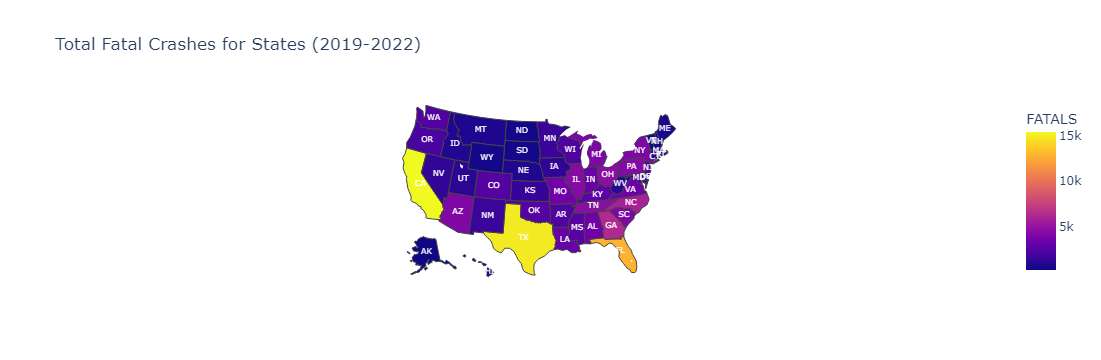

In [78]:
import plotly.express as px
import pandas as pd
import us
pipeline_state = [
    {"$group":{"_id": "$STATENAME", "FATALS": {"$sum": 1}}},
    {"$sort": {"FATALS": -1}}  # Sort by fatalities descending
]
fatalities_by_state = list(accident.aggregate(pipeline_state))
df_state = pd.DataFrame(fatalities_by_state).rename(columns={'_id': 'State'})
print("\nFatalities by State:")

# Create a dictionary to map state names to state abbreviations
state_abbrev_map = {state.name: state.abbr for state in us.states.STATES}

# Add a column with the abbreviations
df_state['State_Abbr'] = df_state['State'].map(state_abbrev_map)

# Drop rows with missing abbreviations (in case of mismatched names)
df_state = df_state.dropna(subset=['State_Abbr'])

print(df_state.head())
  
# Create the choropleth figure using the DataFrame
fig = px.choropleth(
    df_state,
    locations='State_Abbr',
    locationmode='USA-states',
    color='FATALS',
    scope='usa',
    title='Total Fatal Crashes for States (2019-2022)',
    projection='albers usa'
)
# Add state abbreviations as text labels on top of the map
fig.add_scattergeo(
    locations=df_state['State_Abbr'],
    locationmode='USA-states',
    text=df_state['State_Abbr'],
    mode='text',
    hoverinfo='skip',  # Disable hover to avoid redundancy with choropleth info
    showlegend=False,
    textfont=dict(
        size=8,   # Set the size of the text
        color='white'  # Set the color of the text
    )
)
fig.show()

# Save the figure as an image
fig.write_image("choropleth_map.png")  # Saves as a PNG file
fig.write_image("choropleth_map.pdf") 